In [1]:
# Torch Imports
import torch
import torch.nn as nn

# HF Transformers
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

#Datahandeling
import numpy as np
import pandas as pd
import datasets
from datasets import Dataset
from datasets import load_metric,list_metrics
import datetime

# Utils
import os
import pickle
import gc

# Evaluation
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Sat Mar 12 18:56:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:25:00.0  On |                  N/A |
| 29%   33C    P8    10W / 120W |    640MiB /  3072MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060 3GB


# Training

## Setting up the Model and Trainer

In [4]:
train_test_ds = datasets.load_from_disk(os.path.abspath("../data/processed_data"))

In [5]:
MODEL_ARCHITECTURE = 'distilbert-base-uncased' 
TOKENIZER_PATH = r"../data/token"

In [6]:
#tokenizer = AutoTokenizer.from_pretrained(MODEL_ARCHITECTURE)
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

In [3]:
#model = AutoModelForSequenceClassification.from_pretrained(MODEL_ARCHITECTURE, num_labels=3)

def model_init(mode=None,path=None):
    if mode == None:
        return AutoModelForSequenceClassification.from_pretrained(MODEL_ARCHITECTURE, num_labels=3)
    elif mode == "path":
        return AutoModelForSequenceClassification.from_pretrained(path, num_labels=3)
    else:
        print("mode not recognized")

In [4]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

NameError: name 'DataCollatorWithPadding' is not defined

In [9]:
df = pd.read_csv("../data/labeled_data.csv")

In [1]:
class_weights = (1 - (df["class"].value_counts().sort_index()/len(df))).values #calculate classweights to balance loss function to class imbalance
class_weights = torch.from_numpy(class_weights).float().to("cuda") #cass weights into torch.Tensor and push to gpu
print(class_weights)

class CustomTrainer(Trainer): # Subclassing the Trainer class to overwrite the compute_loss function with our customized loss
    #this is the recommended way of doing this, refer to huggingface docs for more detail
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights) # weighting the Crossentropy for our classimbalance
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



cmt= """good_training_args = TrainingArguments(
    output_dir="../results/first_good_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    resume_from_checkpoint = None,
    logging_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    logging_steps = 100,
    eval_steps = 500
)"""

NameError: name 'df' is not defined

#### GPU - Flushing
The Cell below is used for VRAM Flushing so that CUDA Out of Memory errors do not occure or can be solved without restarting the kernel.
Sometimes if a cell errors the VRAM can't be appropriately cleared by torch which is when one needs to uncomment the 1/0 to cause an arithmetic error which unlocks the vram to be cleared by torch commands.
It's a very useful hack from StackOverflow, i'll include the link to the threat if I find it.

In [31]:
#1/0
gc.collect()
torch.cuda.empty_cache()

In [32]:

def compute_metrics(eval_preds): # alternative compute metric function for general stats
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_metric("accuracy").compute(predictions=predictions, references=labels)
    precision = load_metric("precision").compute(predictions=predictions, references=labels,average="weighted")
    f1 = load_metric("f1").compute(predictions=predictions, references=labels,average="weighted")
    recall = load_metric("recall").compute(predictions=predictions, references=labels,average="weighted")
    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1}


def compute_hate_metrics(labels:np.array,predictions:np.array)->dict: # computes recall, precision and f1-score on hate class
    gold_hate_mask = (labels == 0) # yields BoolArray with True at index i if the label at index i is the hateclass
    gold_non_hate_mask = np.logical_not(gold_hate_mask)
    pred_hate_mask = (predictions == 0) # yields BoolArray with True at index i if the prediction at index i is the hateclass
    pred_non_hate_mask = np.logical_not(pred_hate_mask)
    
    tp_mask = gold_hate_mask & pred_hate_mask # True at i if pred = label= True
    tn_mask = gold_non_hate_mask & pred_non_hate_mask # True at i if pred = label = False
    fp_mask = gold_non_hate_mask & pred_hate_mask # True at i if label != hate but pred = hate
    fn_mask = gold_hate_mask & pred_non_hate_mask # True at i if a label = hate but pred != hate
    
    tp = tp_mask.sum()# sum acts on BooleanArrays by adding 1 for every True entry and 0 for every False thus counting True entries
    tn = tn_mask.sum()
    fp = fp_mask.sum()
    fn = fn_mask.sum()
    
    recall = tp/(tp+fn)
    precision = tp/(tp + fp)
    return (recall,precision,(recall + precision)/2)

def compute_hatef1(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    hate_recall,hate_precision,hate_f1 = compute_hate_metrics(labels,predictions) 
    return {"hatef1":hate_f1} # just return the hate_f1 since we are mostly interested in this stat


training_args = TrainingArguments(
    output_dir="../results",
    seed= 42, #fixing random behaviour
    load_best_model_at_end = True, #enable loading the best model at Training end
    metric_for_best_model = "eval_hatef1", #pick the model with the best hate f1-score
    warmup_steps=0,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="steps",
    #resume_from_checkpoint = "" ,
    logging_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), #logdir = yyyymmdd-hhmmss
    logging_steps = 100,
    eval_steps = 500,
    fp16 = True,# Using fp16 for mixed precision to speed up training. 
    #disable_tqdm=True
)



trainer = CustomTrainer(
    model_init = model_init(mode="path",path="../results/last-model"), 
    # pass model via model init function since otherwise the training is non deterministic even with fixed seed
    # since the weights in the Sequential layer are randomly initialized
    # for easier switching between different modes the model_init fct takes a mode and a path and return appropriate models
    # if mode = None then it just returns a basic distil-bert-uncased
    args=training_args,
    train_dataset=train_test_ds["train"],
    eval_dataset=train_test_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_hatef1,
    #callbacks = [tb_callback]
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file ../results/last-model\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_drop

In [33]:
model_path = "../results/training_begin=" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
#save the modelpath when training starts
trainer.train() # start training

loading configuration file ../results/last-model\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "vocab_size": 30522
}

loading weights file ../results/last-model\pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequence

{'loss': 0.3004, 'learning_rate': 4.8242467718794835e-06, 'epoch': 0.07}


  7%|▋         | 200/2788 [03:37<46:59,  1.09s/it]

{'loss': 0.255, 'learning_rate': 4.644906743185079e-06, 'epoch': 0.14}


 11%|█         | 300/2788 [05:26<45:52,  1.11s/it]

{'loss': 0.255, 'learning_rate': 4.4655667144906746e-06, 'epoch': 0.22}


 14%|█▍        | 400/2788 [07:14<40:08,  1.01s/it]

{'loss': 0.2406, 'learning_rate': 4.28622668579627e-06, 'epoch': 0.29}


 18%|█▊        | 500/2788 [08:58<38:34,  1.01s/it]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16


{'loss': 0.2495, 'learning_rate': 4.106886657101866e-06, 'epoch': 0.36}


                                                  
 18%|█▊        | 500/2788 [09:39<38:34,  1.01s/it]Saving model checkpoint to ../results\checkpoint-500
Configuration saved in ../results\checkpoint-500\config.json


{'eval_loss': 0.2681092321872711, 'eval_hatef1': 0.5632429614181439, 'eval_runtime': 40.3779, 'eval_samples_per_second': 61.395, 'eval_steps_per_second': 3.839, 'epoch': 0.36}


Model weights saved in ../results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-500\special_tokens_map.json
 22%|██▏       | 600/2788 [11:22<36:48,  1.01s/it]  

{'loss': 0.332, 'learning_rate': 3.927546628407461e-06, 'epoch': 0.43}


 25%|██▌       | 700/2788 [13:07<36:56,  1.06s/it]

{'loss': 0.2798, 'learning_rate': 3.7482065997130563e-06, 'epoch': 0.5}


 29%|██▊       | 800/2788 [14:57<37:55,  1.14s/it]

{'loss': 0.3182, 'learning_rate': 3.5688665710186515e-06, 'epoch': 0.57}


 32%|███▏      | 900/2788 [16:48<36:04,  1.15s/it]

{'loss': 0.2419, 'learning_rate': 3.389526542324247e-06, 'epoch': 0.65}


 36%|███▌      | 1000/2788 [18:39<30:58,  1.04s/it]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16


{'loss': 0.2697, 'learning_rate': 3.2101865136298426e-06, 'epoch': 0.72}


                                                   
 36%|███▌      | 1000/2788 [19:19<30:58,  1.04s/it]Saving model checkpoint to ../results\checkpoint-1000
Configuration saved in ../results\checkpoint-1000\config.json


{'eval_loss': 0.23537857830524445, 'eval_hatef1': 0.5991925947070097, 'eval_runtime': 40.3878, 'eval_samples_per_second': 61.38, 'eval_steps_per_second': 3.838, 'epoch': 0.72}


Model weights saved in ../results\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-1000\special_tokens_map.json
 39%|███▉      | 1100/2788 [21:03<28:20,  1.01s/it]  

{'loss': 0.3478, 'learning_rate': 3.030846484935438e-06, 'epoch': 0.79}


 43%|████▎     | 1200/2788 [22:47<27:44,  1.05s/it]

{'loss': 0.2966, 'learning_rate': 2.8515064562410332e-06, 'epoch': 0.86}


 47%|████▋     | 1300/2788 [24:32<26:23,  1.06s/it]

{'loss': 0.2451, 'learning_rate': 2.6721664275466288e-06, 'epoch': 0.93}


 50%|█████     | 1400/2788 [26:16<24:16,  1.05s/it]

{'loss': 0.2907, 'learning_rate': 2.492826398852224e-06, 'epoch': 1.0}


 54%|█████▍    | 1500/2788 [28:00<24:20,  1.13s/it]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16


{'loss': 0.2665, 'learning_rate': 2.3134863701578195e-06, 'epoch': 1.08}


                                                   
 54%|█████▍    | 1500/2788 [28:44<24:20,  1.13s/it]Saving model checkpoint to ../results\checkpoint-1500
Configuration saved in ../results\checkpoint-1500\config.json


{'eval_loss': 0.2527189254760742, 'eval_hatef1': 0.5779046155534822, 'eval_runtime': 43.727, 'eval_samples_per_second': 56.693, 'eval_steps_per_second': 3.545, 'epoch': 1.08}


Model weights saved in ../results\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-1500\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-1500\special_tokens_map.json
 57%|█████▋    | 1600/2788 [30:33<20:16,  1.02s/it]  

{'loss': 0.2183, 'learning_rate': 2.1341463414634146e-06, 'epoch': 1.15}


 61%|██████    | 1700/2788 [32:18<18:58,  1.05s/it]

{'loss': 0.2584, 'learning_rate': 1.95480631276901e-06, 'epoch': 1.22}


 65%|██████▍   | 1800/2788 [34:02<17:05,  1.04s/it]

{'loss': 0.2482, 'learning_rate': 1.7772596843615496e-06, 'epoch': 1.29}


 68%|██████▊   | 1900/2788 [35:44<15:05,  1.02s/it]

{'loss': 0.2153, 'learning_rate': 1.597919655667145e-06, 'epoch': 1.36}


 72%|███████▏  | 2000/2788 [37:29<15:12,  1.16s/it]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16


{'loss': 0.2301, 'learning_rate': 1.4185796269727403e-06, 'epoch': 1.43}


                                                   
 72%|███████▏  | 2000/2788 [38:13<15:12,  1.16s/it]Saving model checkpoint to ../results\checkpoint-2000
Configuration saved in ../results\checkpoint-2000\config.json


{'eval_loss': 0.25007203221321106, 'eval_hatef1': 0.5692690866048531, 'eval_runtime': 43.9879, 'eval_samples_per_second': 56.356, 'eval_steps_per_second': 3.524, 'epoch': 1.43}


Model weights saved in ../results\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-2000\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-2000\special_tokens_map.json
 75%|███████▌  | 2100/2788 [40:04<12:27,  1.09s/it]  

{'loss': 0.2104, 'learning_rate': 1.2392395982783357e-06, 'epoch': 1.51}


 79%|███████▉  | 2200/2788 [41:54<10:13,  1.04s/it]

{'loss': 0.1852, 'learning_rate': 1.0598995695839312e-06, 'epoch': 1.58}


 82%|████████▏ | 2300/2788 [43:39<08:36,  1.06s/it]

{'loss': 0.2829, 'learning_rate': 8.805595408895266e-07, 'epoch': 1.65}


 86%|████████▌ | 2400/2788 [45:25<07:06,  1.10s/it]

{'loss': 0.3338, 'learning_rate': 7.012195121951221e-07, 'epoch': 1.72}


 90%|████████▉ | 2500/2788 [47:16<05:16,  1.10s/it]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16


{'loss': 0.2786, 'learning_rate': 5.218794835007174e-07, 'epoch': 1.79}


                                                   
 90%|████████▉ | 2500/2788 [48:00<05:16,  1.10s/it]Saving model checkpoint to ../results\checkpoint-2500
Configuration saved in ../results\checkpoint-2500\config.json


{'eval_loss': 0.2494821697473526, 'eval_hatef1': 0.580919615044865, 'eval_runtime': 43.6504, 'eval_samples_per_second': 56.792, 'eval_steps_per_second': 3.551, 'epoch': 1.79}


Model weights saved in ../results\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-2500\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-2500\special_tokens_map.json
 93%|█████████▎| 2600/2788 [49:51<03:23,  1.08s/it]  

{'loss': 0.2752, 'learning_rate': 3.425394548063128e-07, 'epoch': 1.87}


 97%|█████████▋| 2700/2788 [51:43<01:35,  1.09s/it]

{'loss': 0.2743, 'learning_rate': 1.6319942611190818e-07, 'epoch': 1.94}


100%|██████████| 2788/2788 [53:20<00:00,  1.11s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ../results\checkpoint-1000 (score: 0.5991925947070097).
100%|██████████| 2788/2788 [53:20<00:00,  1.15s/it]

{'train_runtime': 3200.8447, 'train_samples_per_second': 13.936, 'train_steps_per_second': 0.871, 'train_loss': 0.265225251743749, 'epoch': 2.0}


TrainOutput(global_step=2788, training_loss=0.265225251743749, metrics={'train_runtime': 3200.8447, 'train_samples_per_second': 13.936, 'train_steps_per_second': 0.871, 'train_loss': 0.265225251743749, 'epoch': 2.0})

In [35]:
trainer.save_model(model_path) # save best model
tokenizer.save_pretrained(model_path) # save tokenizer for model
os.chdir(model_path) #cd to modeldir
with open("training_args", "wb") as output_file:
    pickle.dump(training_args, output_file) #write the training args into the directory
os.chdir("../../src") #cd back to initial working directory


Saving model checkpoint to ../results/training_begin=20220312-202358
Configuration saved in ../results/training_begin=20220312-202358\config.json
Model weights saved in ../results/training_begin=20220312-202358\pytorch_model.bin
tokenizer config file saved in ../results/training_begin=20220312-202358\tokenizer_config.json
Special tokens file saved in ../results/training_begin=20220312-202358\special_tokens_map.json
tokenizer config file saved in ../results/training_begin=20220312-202358\tokenizer_config.json
Special tokens file saved in ../results/training_begin=20220312-202358\special_tokens_map.json


## Predictions and Evaluation of Training

In [36]:
predictions = trainer.predict(train_test_ds["test"]) 
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Prediction *****
  Num examples = 2479
  Batch size = 16
100%|██████████| 155/155 [00:43<00:00,  3.67it/s]

(2479, 3) (2479,)


In [37]:
y_preds = np.argmax(predictions.predictions, axis=-1) #get predictions

In [39]:
print(classification_report(y_true=predictions.label_ids,y_pred = y_preds))

              precision    recall  f1-score   support

           0       0.52      0.68      0.59       137
           1       0.97      0.94      0.96      1908
           2       0.95      0.97      0.96       434

    accuracy                           0.93      2479
   macro avg       0.81      0.86      0.83      2479
weighted avg       0.94      0.93      0.94      2479



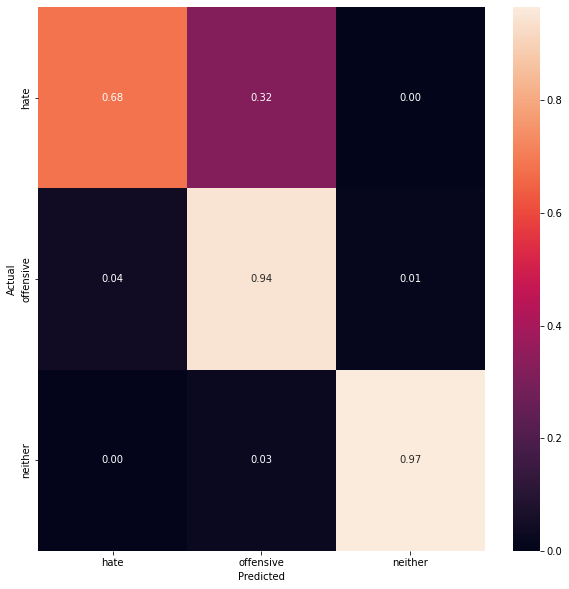

In [40]:
target_names = ("hate","offensive","neither")
cm = confusion_matrix(y_true=predictions.label_ids,y_pred=y_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)